In [1]:
import pandas as pd
import numpy as np

#import datetime
from datetime import datetime, date, timedelta
import time

from yahooquery import Ticker

import requests
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xlwings as xw




In [3]:

wb = xw.Book("daily.xlsm")
sht2 = wb.sheets['options_chain']
sht3 = wb.sheets['ticker_list']
sht1 = wb.sheets['correl']

In [4]:
shtlist= sht3.range('A1').options(pd.DataFrame, 
                             header=False,
                             index=False, 
                             expand='table').value

In [5]:
stonks=shtlist.iloc[1:,0].tolist()

In [6]:
stonks

['AAPL',
 'MSFT',
 'AMZN',
 'GOOG',
 'NVDA',
 'TSLA',
 'GOOGL',
 'FB',
 'AVGO',
 'COST',
 'CSCO',
 'PEP',
 'CMCSA',
 'ADBE',
 'INTC',
 'AMD',
 'QCOM',
 'TXN',
 'TMUS',
 'NFLX',
 'AMGN',
 'HON',
 'INTU',
 'PYPL',
 'AMAT',
 'QQQ',
 'KO',
 'SBUX',
 'WMT',
 'JNJ',
 'PG',
 'UVXY',
 'SPY',
 'HD',
 'USO']

In [8]:

stonks2 = Ticker(stonks, asynchronous=True)

In [9]:
# 90 days worth of data
d = datetime.today() - timedelta(days=120)
yq_data = stonks2.history(start=d, interval='1d')

In [10]:
yq_data.reset_index(inplace=True)
yq_data

,symbol,date,close,open,low,high,volume,adjclose,dividends
0,AAPL,2021-11-29,160.240005,159.369995,158.789993,161.190002,88748200,160.036102,0.0
1,AAPL,2021-11-30,165.300003,159.990005,159.919998,165.520004,174048100,165.089676,0.0
2,AAPL,2021-12-01,164.770004,167.479996,164.529999,170.300003,152052500,164.560349,0.0
3,AAPL,2021-12-02,163.759995,158.740005,157.800003,164.199997,136739200,163.551620,0.0
4,AAPL,2021-12-03,161.839996,164.020004,159.720001,164.960007,118023100,161.634064,0.0
...,...,...,...,...,...,...,...,...,...
2900,USO,2022-03-22,78.559998,78.690002,77.550003,79.650002,4175300,78.559998,0.0
2901,USO,2022-03-23,81.949997,81.379997,81.080002,82.480003,6155100,81.949997,0.0
2902,USO,2022-03-24,79.750000,81.669998,79.300003,81.779999,4417200,79.750000,0.0
2903,USO,2022-03-25,80.739998,78.879997,78.410004,81.730003,7534500,80.739998,0.0


In [11]:
#get latest volume
today_volume = yq_data.groupby('symbol')['volume'].last().to_dict()

In [12]:
# drop columns that are not used
yq_data = yq_data.drop(columns = ['open', 'low', 'close', 'high'])# 'dividends'])

In [13]:
# calculate log return using daily historical price data
yq_data = yq_data.assign(logret=np.log(yq_data.adjclose).groupby(yq_data.symbol).diff()) 

In [14]:
yq_data2 = yq_data[["date", "symbol","logret"]]

In [15]:
yq_data2

,date,symbol,logret
0,2021-11-29,AAPL,NaN
1,2021-11-30,AAPL,0.031089
2,2021-12-01,AAPL,-0.003211
3,2021-12-02,AAPL,-0.006149
4,2021-12-03,AAPL,-0.011794
...,...,...,...
2900,2022-03-22,USO,-0.012397
2901,2022-03-23,USO,0.042247
2902,2022-03-24,USO,-0.027213
2903,2022-03-25,USO,0.012337


In [16]:
yq_data2.set_index('date')

,symbol,logret
date,,
2021-11-29,AAPL,NaN
2021-11-30,AAPL,0.031089
2021-12-01,AAPL,-0.003211
2021-12-02,AAPL,-0.006149
2021-12-03,AAPL,-0.011794
...,...,...
2022-03-22,USO,-0.012397
2022-03-23,USO,0.042247
2022-03-24,USO,-0.027213


In [17]:
yq_dataT=yq_data2.pivot_table(index = ["date"], 
              columns = "symbol" , 
              values = "logret", 
              aggfunc = "sum",
              fill_value = "").reset_index()

In [18]:
yq_dataT.head()

symbol,date,AAPL,ADBE,AMAT,AMD,AMGN,AMZN,AVGO,CMCSA,COST,...,QCOM,QQQ,SBUX,SPY,TMUS,TSLA,TXN,USO,UVXY,WMT
0,2021-11-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-11-30,0.031089,-0.025993,-0.027011,-0.022107,-0.022817,-0.015421,-0.019070,-0.030541,-0.028332,...,-0.017459,-0.014795,-0.009893,-0.019649,-0.041318,0.006811,-0.010394,-0.046093,0.197643,-0.014121
2,2021-12-01,-0.003211,-0.018746,0.029983,-0.060250,0.009608,-0.018229,0.001949,-0.018171,-0.017845,...,-0.023910,-0.017159,-0.008978,-0.011169,-0.019395,-0.044441,-0.003176,-0.018326,0.103605,-0.025130
3,2021-12-02,-0.006149,0.021772,-0.034750,0.010474,0.001841,-0.001849,-0.004173,0.048130,-0.008206,...,0.007940,0.007181,0.025083,0.015200,0.033539,-0.009543,0.009446,0.026226,-0.090052,-0.012252
4,2021-12-03,-0.011794,-0.085973,-0.004516,-0.045276,0.006293,-0.013936,0.010211,0.005422,0.006487,...,-0.002942,-0.017542,-0.001617,-0.008739,0.021603,-0.066352,-0.001034,-0.006024,0.122047,0.014946


In [19]:
# variance - covariance Matrix
cov_matrix = yq_dataT.cov()
cov_matrix

symbol,AAPL,ADBE,AMAT,AMD,AMGN,AMZN,AVGO,CMCSA,COST,CSCO,...,QCOM,QQQ,SBUX,SPY,TMUS,TSLA,TXN,USO,UVXY,WMT
symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000364,0.000403,0.000411,0.000526,0.000092,0.000271,0.000324,0.000086,0.000161,0.000155,...,0.000400,0.000296,0.000244,0.000196,0.000054,0.000539,0.000232,-0.000065,-0.001006,2.178825e-05
ADBE,0.000403,0.001015,0.000590,0.000768,0.000086,0.000441,0.000495,0.000145,0.000268,0.000227,...,0.000594,0.000471,0.000375,0.000304,0.000072,0.000774,0.000384,-0.000082,-0.001614,3.505551e-05
AMAT,0.000411,0.000590,0.001026,0.000967,0.000129,0.000434,0.000560,0.000148,0.000255,0.000248,...,0.000760,0.000473,0.000368,0.000311,0.000148,0.000814,0.000466,-0.000090,-0.001643,9.896906e-06
AMD,0.000526,0.000768,0.000967,0.001631,0.000139,0.000606,0.000689,0.000244,0.000306,0.000328,...,0.000937,0.000613,0.000435,0.000399,0.000182,0.001189,0.000529,-0.000125,-0.002240,2.107814e-05
AMGN,0.000092,0.000086,0.000129,0.000139,0.000203,0.000077,0.000088,0.000068,0.000040,0.000089,...,0.000106,0.000082,0.000040,0.000076,0.000048,0.000059,0.000087,0.000023,-0.000465,2.518258e-05
AMZN,0.000271,0.000441,0.000434,0.000606,0.000077,0.000731,0.000348,0.000109,0.000148,0.000154,...,0.000460,0.000371,0.000254,0.000240,0.000079,0.000617,0.000240,-0.000050,-0.001445,2.941242e-05
AVGO,0.000324,0.000495,0.000560,0.000689,0.000088,0.000348,0.000596,0.000111,0.000266,0.000229,...,0.000547,0.000360,0.000291,0.000243,0.000099,0.000594,0.000348,-0.000092,-0.001313,3.311902e-05
CMCSA,0.000086,0.000145,0.000148,0.000244,0.000068,0.000109,0.000111,0.000243,0.000066,0.000099,...,0.000165,0.000130,0.000134,0.000105,0.000113,0.000198,0.000112,-0.000011,-0.000514,3.542476e-05
COST,0.000161,0.000268,0.000255,0.000306,0.000040,0.000148,0.000266,0.000066,0.000277,0.000139,...,0.000253,0.000177,0.000162,0.000128,0.000127,0.000239,0.000172,-0.000007,-0.000622,8.509649e-05


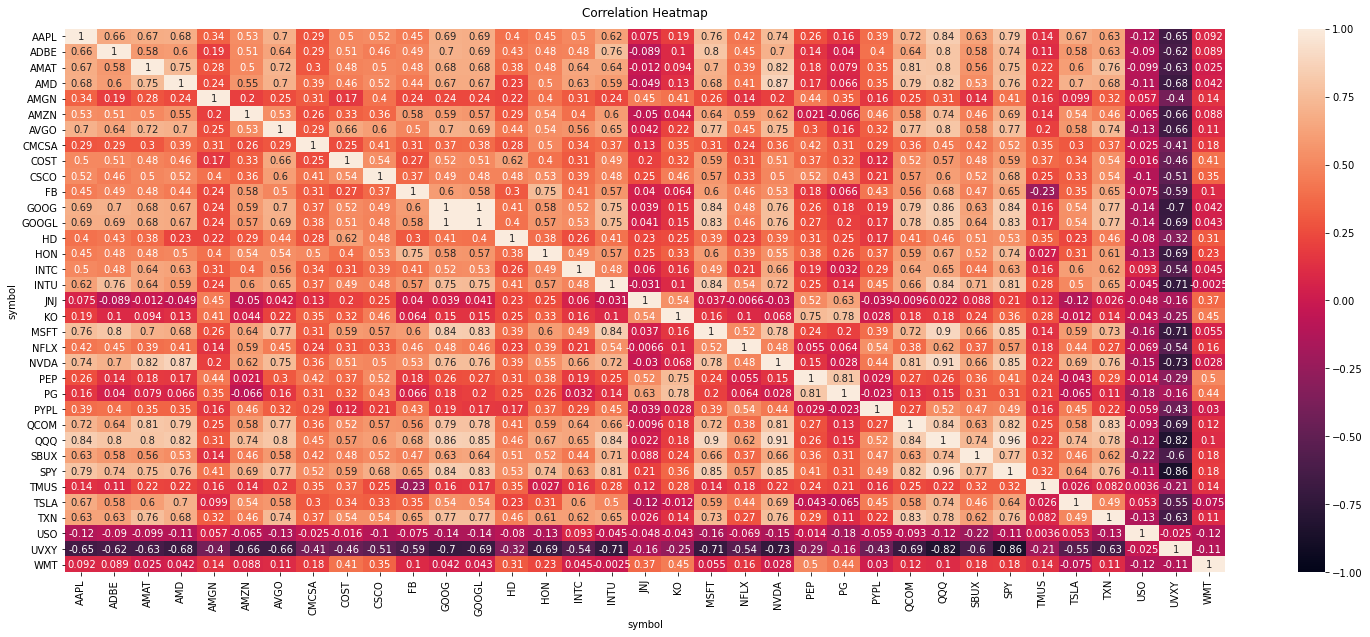

In [20]:
#correlation matricx

plt.figure(figsize=(26, 10))
heatmap1 = sns.heatmap(yq_dataT.corr(), vmin=-1, vmax=1, annot=True)

heatmap1.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

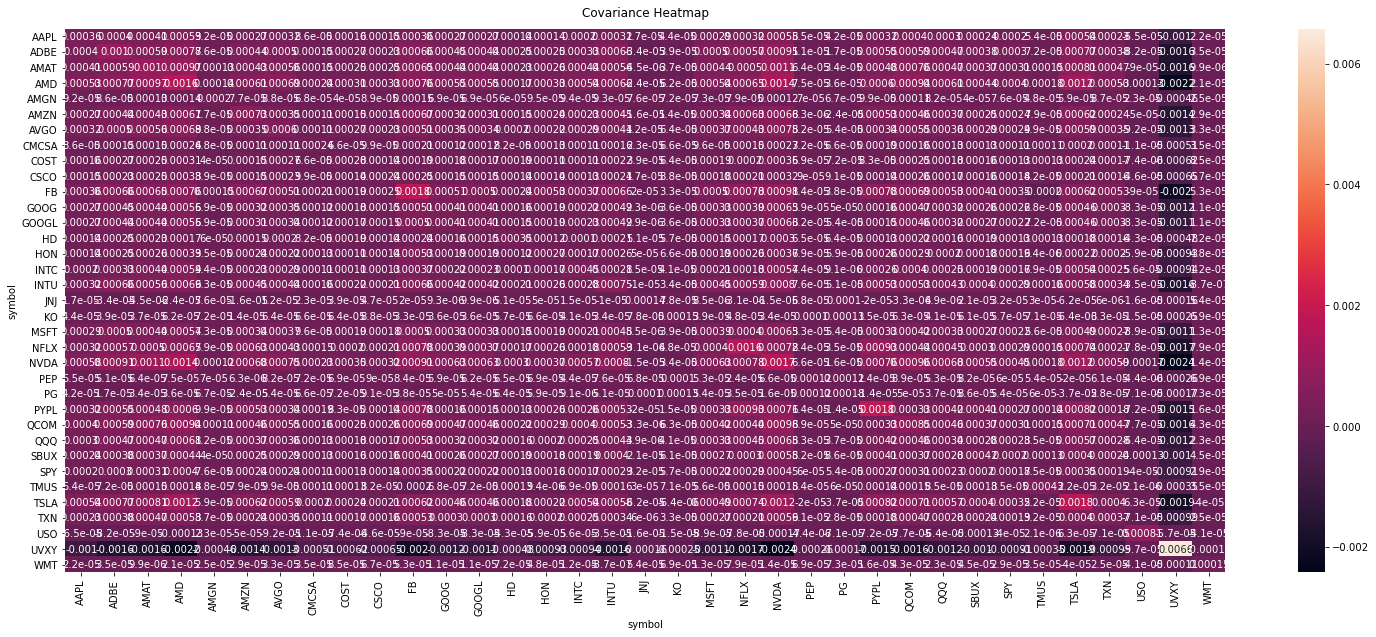

In [21]:
plt.figure(figsize=(26, 10))
heatmap2 = sns.heatmap(cov_matrix, annot=True)

heatmap2.set_title('Covariance Heatmap', fontdict={'fontsize':12}, pad=12);

In [22]:
avg_rets = yq_dataT.mean()
avg_rets

symbol
AAPL     0.001071
ADBE    -0.005677
AMAT    -0.001177
AMD     -0.003687
AMGN     0.002056
AMZN    -0.000947
AVGO     0.001480
CMCSA   -0.001028
COST     0.000037
CSCO    -0.000102
FB      -0.005137
GOOG    -0.000389
GOOGL   -0.000328
HD      -0.003164
HON     -0.000527
INTC     0.000531
INTU    -0.005030
JNJ      0.001323
KO       0.001649
MSFT    -0.001231
NFLX    -0.007002
NVDA    -0.002273
PEP      0.000244
PG       0.000374
PYPL    -0.006077
QCOM    -0.001746
QQQ     -0.001267
SBUX    -0.002817
SPY     -0.000236
TMUS     0.001118
TSLA    -0.001437
TXN     -0.000529
USO      0.005803
UVXY    -0.002615
WMT      0.000166
dtype: float64

Text(0.5, 1.0, 'Stock Daily returns')

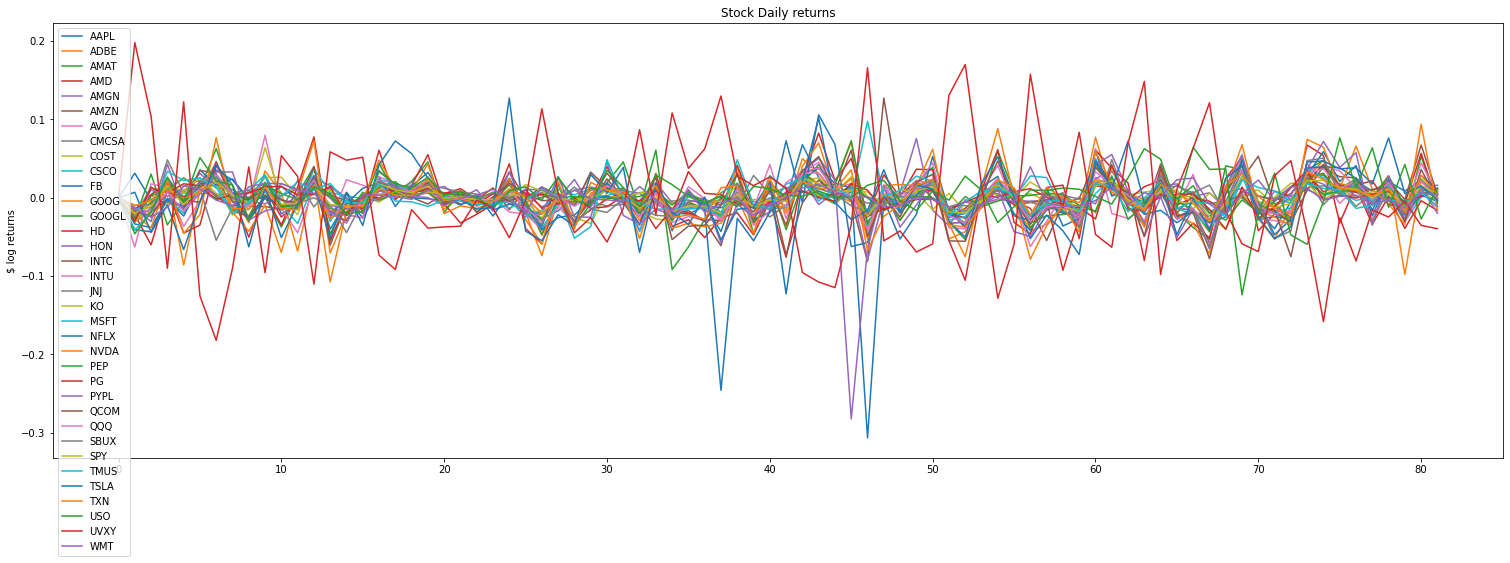

In [23]:
# Plot returns
yq_dataT.plot(figsize=(26,8))
plt.legend(loc='upper left')
plt.ylabel("$ log returns")
plt.title("Stock Daily returns")


In [24]:
sht1["A1"].options(pd.DataFrame, index=False, header=1,expand='table').value = yq_dataT.corr().reset_index()

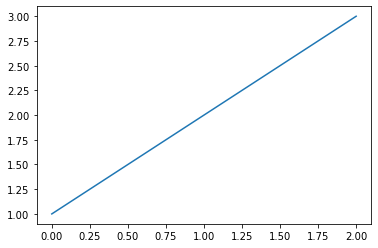

In [25]:
#fig = plt.figure()
#plt.plot([1, 2, 3])

In [26]:
#sht1.pictures.add(fig, name='MyPlot', update=True)

<Picture 'MyPlot' in <Sheet [daily.xlsm]test>>